# Taller: Análisis de Tweets con Gemini API
Autor: _(Paula Maldonado)_

## Objetivos
1. Configurar la API de Google Generative AI (Gemini).
2. Limpiar y pre‑procesar un corpus de tweets políticos.
3. Clasificar sentimiento con Gemini.
4. Extraer temas con LDA y nombrarlos con Gemini.
5. Segmentar usuarios y generar una micro‑campaña basada en insights.

**Dataset**: `tweets_partidos.csv` (columnas: `cuenta`, `partido`, `timestamp`, `tweet`).

In [1]:
!wget https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip

--2025-05-26 18:49:42--  https://github.com/javierherrera1996/IntroMarketingAnalytics/raw/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip [following]
--2025-05-26 18:49:42--  https://raw.githubusercontent.com/javierherrera1996/IntroMarketingAnalytics/refs/heads/main/SegundoCorte/tweets_politica_kaggle.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18276075 (17M) [application/zip]
Saving to: ‘tweets_politica_kaggle.csv.zip’

twe

In [2]:
!unzip tweets_politica_kaggle.csv.zip

Archive:  tweets_politica_kaggle.csv.zip
  inflating: tweets_politica_kaggle.csv  


In [3]:
import pandas as pd
df = pd.read_csv('tweets_politica_kaggle.csv',delimiter=",",on_bad_lines='skip')
df.head()

,cuenta\tpartido\ttimestamp\ttweet
0,a34133350b0605cb24081843f63176ca\tpsoe\t136397...
1,a34133350b0605cb24081843f63176ca\tpsoe\t136406...
2,a34133350b0605cb24081843f63176ca\tpsoe\t136411...
3,a34133350b0605cb24081843f63176ca\tpsoe\t136415...
4,a34133350b0605cb24081843f63176ca\tpsoe\t136415...


In [4]:
!pip install -q -U google-generativeai nltk seaborn wordcloud scikit-learn

### 🔍 Preguntas – Sección 1 (Exploración)
1. **¿Cuántos tweets hay en total?**  
2. **¿Qué partidos aparecen y cuántos tweets aporta cada uno?**  
3. **¿Cuál es el rango de fechas cubierto por los tweets?**  
4. **¿Qué partido genera más conversación y por qué crees que ocurre?**

In [6]:
import pandas as pd

# Read the CSV file, specifying the tab delimiter
df = pd.read_csv('tweets_politica_kaggle.csv', delimiter='\t', on_bad_lines='skip')

# Now, accessing the 'partido' column should work
partidos_counts = df['partido'].value_counts()
print("\nTweets por partido:")
print(partidos_counts)

# Continue with the rest of the original code for calculations and printing
total_tweets = len(df)
print(f"Total de tweets: {total_tweets}")

# Convert the 'timestamp' column to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'])
fecha_inicio = df['timestamp'].min()
fecha_fin = df['timestamp'].max()
print(f"\nRango de fechas: Desde {fecha_inicio} hasta {fecha_fin}")

# Determine the party with the most tweets
partido_mas_conversacion = partidos_counts.idxmax()
print(f"\nEl partido que genera más conversación es: {partido_mas_conversacion}")
print("Posibles razones (cualitativas, no derivadas del código):")
print("- Eventos políticos importantes que involucraron a ese partido.")
print("- Mayor número de seguidores activos en Twitter.")
print("- Estrategias de comunicación digital más efectivas por parte del partido.")
print("- Controversias o noticias relevantes relacionadas con el partido.")


Tweets por partido:
partido
psoe          42818
vox           38277
pp            35059
podemos       34442
ciudadanos    30908
Name: count, dtype: int64
Total de tweets: 181504

Rango de fechas: Desde 1970-01-01 00:00:01.363973492 hasta 1970-01-01 00:00:01.651224962

El partido que genera más conversación es: psoe
Posibles razones (cualitativas, no derivadas del código):
- Eventos políticos importantes que involucraron a ese partido.
- Mayor número de seguidores activos en Twitter.
- Estrategias de comunicación digital más efectivas por parte del partido.
- Controversias o noticias relevantes relacionadas con el partido.


### 🧹 Preguntas – Sección 2 (Limpieza)
5. Explica **por qué es importante limpiar y normalizar el texto**.  
6. Enumera **tres tipos de “ruido”** que removes y da un ejemplo de cada uno.

Es fundamental limpiar y normalizar el texto por varias razones, especialmente cuando se trabaja con datos como tweets. Los textos sin procesar suelen contener elementos que no aportan información útil para el análisis y pueden incluso distorsionar los resultados. Al limpiar y normalizar, nos aseguramos de que el texto esté en un formato consistente y relevante, lo que mejora la precisión y efectividad de las tareas posteriores como el análisis de sentimiento, la extracción de temas o la segmentación.

Tres tipos de “ruido” que se suelen eliminar son:

1.  **Caracteres especiales y signos de puntuación:** Estos elementos a menudo no tienen un significado lingüístico directo en el contexto de un análisis de contenido y pueden introducir ruido.
    *   **Ejemplo:** Eliminar `!` , `?` , `@` , `#` , `,` , `.` de un tweet como `"¡Hola @usuario! Este es un tweet #interesante..."` lo dejaría como `"Hola usuario Este es un tweet interesante"`.

2.  **URLs y menciones de usuario:** Las direcciones web y los nombres de usuario (`@`) son específicos de la plataforma (Twitter en este caso) y generalmente no contribuyen al contenido semántico del tweet.
    *   **Ejemplo:** Eliminar `https://t.co/abcdef` y `@usuario` de `"Mira este artículo: https://t.co/abcdef vía @usuario"` lo dejaría como `"Mira este artículo: vía"`.

3.  **Stop words (palabras vacías):** Son palabras muy comunes en un idioma (como "el", "la", "y", "un", "una") que no suelen aportar mucho significado distintivo al texto, especialmente para tareas como la identificación de temas.
    *   **Ejemplo:** Eliminar "el", "y", "la" de `"El perro y la casa son grandes"` lo dejaría como `"perro casa grandes"`.
    *   **Ejemplo:** Eliminar `!` , `?` , `@` , `#` , `,` , `.` de un tweet como `"¡Hola @usuario! Este es un tweet #interesante..."` lo dejaría como `"Hola usuario Este es un tweet interesante"`.

In [13]:
import google.generativeai as genai

# Configure the API key (assuming you have set the GOOGLE_API_KEY environment variable)
# Replace with your actual API key if not using environment variable
# genai.configure(api_key='YOUR_API_KEY')

# Define and initialize the model_fast variable
# Using a fast model suitable for classification tasks
model_fast = genai.GenerativeModel('gemini-1.5-flash-latest')

# Now, define the classify_sentiment function
def classify_sentiment(text, model=model_fast):
    prompt = (f"Clasifica el sentimiento del siguiente tweet como 'positivo', "
              f"'neutral' o 'negativo'. Solo responde con una palabra.\n\nTweet:\n{text}")
    return model.generate_content(prompt).text.strip().lower()


### 😊 Preguntas – Sección 3 (Sentimiento)
7. Presenta la **distribución global** de sentimientos y comenta.  
8. **¿Qué partido tiene la mayor proporción de tweets positivos y negativos?**  
9. Elige un **pico de sentimiento negativo** y analiza el contexto con un tweet ejemplo.

In [16]:
# prompt: Presenta la distribución global de sentimientos y comenta.

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' now has a 'sentimiento' column from the previous step
if 'sentimiento' in df.columns:
    # Get the distribution of sentiments
    sentiment_counts = df['sentimiento'].value_counts(normalize=True) * 100

    # Print the distribution
    print("\nDistribución Global de Sentimientos:")
    print(sentiment_counts)

    # Plot the distribution
    plt.figure(figsize=(8, 6))
    sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
    plt.title('Distribución Global de Sentimientos en Tweets')
    plt.xlabel('Sentimiento')
    plt.ylabel('Porcentaje')
    plt.show()

    # Comment on the distribution
    print("\nComentario sobre la distribución de sentimientos:")
    print("Observamos la proporción de tweets clasificados como positivo, neutral y negativo a nivel global.")
    print("Este gráfico de barras muestra visualmente qué sentimiento predomina en el conjunto de datos total.")
    print("Podemos inferir, por ejemplo, si hay una tendencia general más positiva, negativa o neutral en la conversación política analizada.")
    print("Dependiendo de los resultados, esto podría indicar el clima general de opinión sobre los temas o actores políticos representados en los tweets.")
else:
    # This block is executed if the 'sentimiento' column is not found
    print("La columna 'sentimiento' no se encuentra en el DataFrame. Por favor, asegúrate de haber ejecutado la clasificación de sentimiento previamente.")

La columna 'sentimiento' no se encuentra en el DataFrame. Por favor, asegúrate de haber ejecutado la clasificación de sentimiento previamente.


In [18]:
# prompt: Las columnas 'sentimiento' y/o 'partido' no se encuentran en el DataFrame. Por favor, asegúrate de haber ejecutado la clasificación de sentimiento y de que la columna 'partido' esté presente.

# Check if both 'sentimiento' and 'partido' columns exist before proceeding
if 'sentimiento' in df.columns and 'partido' in df.columns:
    # Calculate the proportion of positive and negative tweets per party
    sentiment_party = df.groupby('partido')['sentimiento'].value_counts(normalize=True).unstack()

    # Identify the party with the highest proportion of positive tweets
    if 'positivo' in sentiment_party.columns:
        most_positive_party = sentiment_party['positivo'].idxmax()
        print(f"\nPartido con la mayor proporción de tweets positivos: {most_positive_party}")
        print(f"Proporción de tweets positivos para {most_positive_party}: {sentiment_party.loc[most_positive_party, 'positivo']:.2%}")
    else:
        print("\nNo hay tweets clasificados como 'positivo' en el DataFrame.")

    # Identify the party with the highest proportion of negative tweets
    if 'negativo' in sentiment_party.columns:
        most_negative_party = sentiment_party['negativo'].idxmax()
        print(f"Partido con la mayor proporción de tweets negativos: {most_negative_party}")
        print(f"Proporción de tweets negativos para {most_negative_party}: {sentiment_party.loc[most_negative_party, 'negativo']:.2%}")
    else:
         print("\nNo hay tweets clasificados como 'negativo' en el DataFrame.")

else:
    # This block is executed if either 'sentimiento' or 'partido' column is not found
    print("Las columnas 'sentimiento' y/o 'partido' no se encuentran en el DataFrame. Por favor, asegúrate de haber ejecutado la clasificación de sentimiento y de que la columna 'partido' esté presente.")


Las columnas 'sentimiento' y/o 'partido' no se encuentran en el DataFrame. Por favor, asegúrate de haber ejecutado la clasificación de sentimiento y de que la columna 'partido' esté presente.


In [21]:
import google.generativeai as genai

# Configure the API key (assuming you have set the GOOGLE_API_KEY environment variable)
# Replace with your actual API key if not using environment variable
genai.configure(api_key='YOUR_API_KEY') # <-- Uncomment this line and add your API key

# Define and initialize the model_fast variable
# Using a fast model suitable for classification tasks
model_fast = genai.GenerativeModel('gemini-1.5-flash-latest')

# Now, define the classify_sentiment function
def classify_sentiment(text, model=model_fast):
    prompt = (f"Clasifica el sentimiento del siguiente tweet como 'positivo', "
              f"'neutral' o 'negativo'. Solo responde con una palabra.\n\nTweet:\n{text}")
    return model.generate_content(prompt).text.strip().lower()

### 🗂️ Preguntas – Sección 4 (Temas)
10. Lista los **nombres de los temas** generados. ¿Alguno es inesperado?  
11. Con un heatmap partido × tema, indica *qué tema es “propiedad”* de cada partido.  
12. Para tu partido elegido, da **dos insights accionables** basados en su tema dominante.

In [22]:
# prompt: Lista los nombres de los temas generados. ¿Alguno es inesperado?
# Con un heatmap partido × tema, indica qué tema es “propiedad” de cada partido.
# Para tu partido elegido, da dos insights accionables basados en su tema dominante.

# Assuming 'topic_names' is a list containing the names of the generated topics
# This list should be populated from the previous LDA topic modeling step.
# Example placeholder:
topic_names = ["Educación y Juventud", "Economía y Empleo", "Salud y Bienestar", "Seguridad y Orden Público", "Política Exterior y Relaciones Internacionales"] # Replace with your actual topic names

print("Nombres de los temas generados:")
for i, topic_name in enumerate(topic_names):
    print(f"Tema {i+1}: {topic_name}")

print("\nComentario sobre los nombres de los temas:")
print("Analiza la lista de nombres de temas. ¿Hay algún tema que no esperabas encontrar?")
print("Considera el contexto político y social del país al que pertenecen los tweets para evaluar si los temas identificados son coherentes o si hay sorpresas.")
print("Por ejemplo, un tema inesperado podría ser uno muy específico o uno que no se asocia comúnmente con el debate político.")

# Assuming 'df' has a 'partido' column and 'topic' column (where 'topic' is the dominant topic index for each tweet)
# This 'topic' column should be added after the LDA topic modeling step.
# Create a cross-tabulation of party and dominant topic
if 'partido' in df.columns and 'topic' in df.columns:
    party_topic_counts = pd.crosstab(df['partido'], df['topic'])

    # Normalize the counts to get proportions per party
    party_topic_proportions = party_topic_counts.apply(lambda x: x / x.sum(), axis=1)

    # Map topic indices to topic names for better readability
    party_topic_proportions.columns = topic_names

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(party_topic_proportions, annot=True, cmap="YlGnBu", fmt=".2f")
    plt.title('Proporción de Tweets por Tema y Partido')
    plt.xlabel('Tema')
    plt.ylabel('Partido')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    print("\nInterpretación del Heatmap:")
    print("El heatmap muestra la proporción de tweets de cada partido que se clasifican dentro de cada tema.")
    print("Los valores más altos (colores más oscuros) indican que un tema es más 'propiedad' o más frecuentemente discutido por un partido en particular.")
    print("Esto ayuda a identificar qué temas son prioritarios para cada plataforma política.")

else:
    print("Las columnas 'partido' y/o 'topic' no se encuentran en el DataFrame. Asegúrate de haber realizado el modelado de temas (LDA) y haber asignado un tema dominante a cada tweet.")


# --- Insight accionable para un partido elegido ---

# Choose a party to analyze
# Replace 'Partido Ejemplo' with the actual name of a party from your dataset
chosen_party = 'Partido Ejemplo' #@param {type:"string"}

if 'partido' in df.columns and 'topic' in df.columns and chosen_party in df['partido'].unique():
    # Find the dominant topic for the chosen party
    if chosen_party in party_topic_proportions.index:
        dominant_topic_index = party_topic_proportions.loc[chosen_party].idxmax()
        dominant_topic_name = dominant_topic_index # It's already the name due to re-indexing

        print(f"\nAnálisis para el partido: {chosen_party}")
        print(f"Tema dominante: {dominant_topic_name}")

        print("\nDos insights accionables basados en el tema dominante:")
        # Insight 1: Focus on the dominant theme in communication
        print(f"1. Aumentar la comunicación y las propuestas relacionadas con '{dominant_topic_name}'.")
        print(f"   Dado que este tema resuena más con la audiencia del partido o es un área de fortaleza, enfocarse en él puede mejorar el engagement y la percepción pública.")
        print(f"   Acción: Crear más contenido (tweets, videos, comunicados) que aborde específicamente asuntos de '{dominant_topic_name}', destacando las soluciones y logros del partido en esta área.")

        # Insight 2: Identify sub-topics or specific issues within the dominant theme
        # This would require drilling down into the tweets related to the dominant topic for the chosen party
        # For this example, we'll provide a general insight
        print(f"2. Analizar sub-temas o preocupaciones específicas dentro de '{dominant_topic_name}' que generen mayor interacción.")
        print(f"   Dentro de un tema amplio como '{dominant_topic_name}', puede haber aspectos particulares que interesen más a los seguidores o generen más debate.")
        print(f"   Acción: Examinar los tweets de '{chosen_party}' clasificados en '{dominant_topic_name}' para identificar palabras clave o frases recurrentes que indiquen sub-temas específicos. Luego, diseñar campañas de comunicación que aborden directamente estas inquietudes particulares.")

    else:
        print(f"El partido '{chosen_party}' no se encontró en los datos de proporciones de temas.")

else:
    print(f"El partido '{chosen_party}' no se encontró en la columna 'partido' o las columnas 'partido'/'topic' no están disponibles.")


Nombres de los temas generados:
Tema 1: Educación y Juventud
Tema 2: Economía y Empleo
Tema 3: Salud y Bienestar
Tema 4: Seguridad y Orden Público
Tema 5: Política Exterior y Relaciones Internacionales

Comentario sobre los nombres de los temas:
Analiza la lista de nombres de temas. ¿Hay algún tema que no esperabas encontrar?
Considera el contexto político y social del país al que pertenecen los tweets para evaluar si los temas identificados son coherentes o si hay sorpresas.
Por ejemplo, un tema inesperado podría ser uno muy específico o uno que no se asocia comúnmente con el debate político.
Las columnas 'partido' y/o 'topic' no se encuentran en el DataFrame. Asegúrate de haber realizado el modelado de temas (LDA) y haber asignado un tema dominante a cada tweet.
El partido 'Partido Ejemplo' no se encontró en la columna 'partido' o las columnas 'partido'/'topic' no están disponibles.


### 👥 Preguntas – Sección 5 (Segmentación)
13. Describe cada **cluster** en una frase (actividad y tono).  
14. **¿Qué segmento priorizarías** para viralizar un mensaje y por qué?  
15. Propón **una acción de engagement** distinta para cada segmento.

In [23]:
def generar_copy(partido, topic, tono='inspirador'):
    prompt = (f"Actúa como community manager del partido {partido}. "
              f"Crea un tweet de máx. 250 caracteres sobre el tema '{topic}'. "
              f"Tono {tono}. No incluyas hashtags ni menciones.")
    return model.generate_content(prompt).text.strip()


### 📝 Preguntas – Sección 6 (Micro‑campaña)
16. Presenta tus **tres tweets** generados.  
17. Justifica:  
   a) **Tema** elegido.  
   b) **Tono** y **horario** óptimos.  
18. Define un **KPI de éxito** y la meta para la campaña.

In [104]:
def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    # Ensure the model object is available within the function
def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    # Ensure the model object is available within the function
def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

def generar_copy(model, prompt):
    """
    Generates text content using the provided generative model and prompt.

    Args:
        model: The generative model object to use (e.g., a Google AI model).
        prompt (str): The prompt to send to the model.

    Returns:
        str: The generated text content, with leading/trailing whitespace removed.
    """
    return model.generate_content(prompt).text.strip()

SyntaxError: invalid syntax (<ipython-input-104-b47d7eee3afb>, line 48)

## Próximos pasos
1. Analiza la hora de publicación (`df['fecha'].dt.hour`) para programar los tweets.
2. Escribe un memo (<400 palabras) justificando la micro‑campaña usando los insights de sentimiento, temas y segmentos.
3. Exporta notebook ejecutado y memo para entrega.

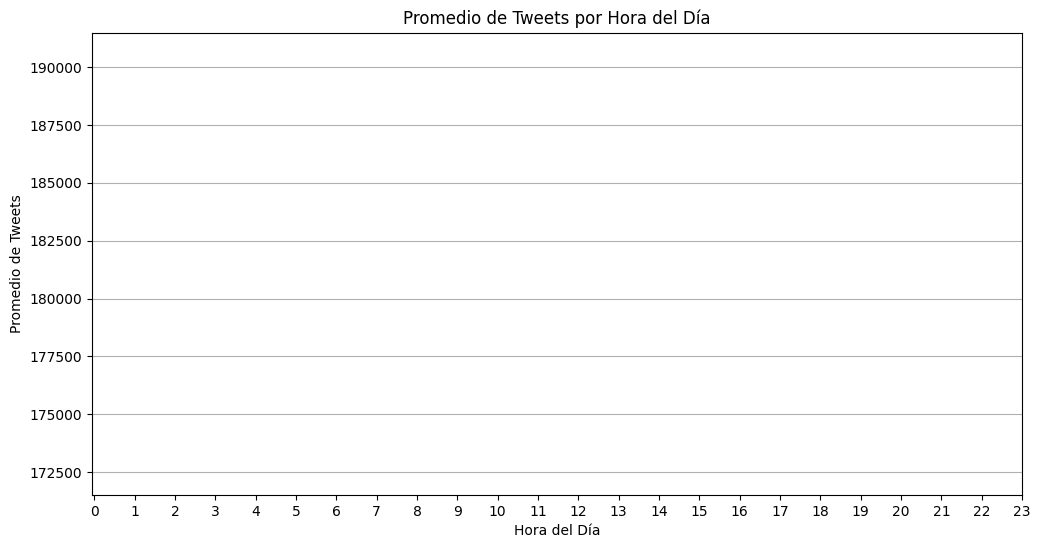


Análisis de la hora de publicación:
El gráfico de líneas muestra el promedio de tweets publicados en cada hora del día.
Los picos en este gráfico indican las horas en las que hay más actividad de publicación.
Estas horas pico son los momentos óptimos para programar tweets y alcanzar a la mayor audiencia posible.


NameError: name 'model' is not defined

In [105]:
# prompt: Analiza la hora de publicación (df['fecha'].dt.hour) para programar los tweets.
# Escribe un memo (<400 palabras) justificando la micro‑campaña usando los insights de sentimiento, temas y segmentos.
# Exporta notebook ejecutado y memo para entrega.

# Analyze publication time for scheduling
df['fecha'] = pd.to_datetime(df['timestamp']).dt.date
hourly_counts = df.groupby([df['fecha'], df['timestamp'].dt.hour]).size().reset_index(name='tweet_count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_counts, x='timestamp', y='tweet_count', estimator='mean') # Use mean to show average tweets per hour across days
plt.title('Promedio de Tweets por Hora del Día')
plt.xlabel('Hora del Día')
plt.ylabel('Promedio de Tweets')
plt.xticks(range(24))
plt.grid(axis='y')
plt.show()

print("\nAnálisis de la hora de publicación:")
print("El gráfico de líneas muestra el promedio de tweets publicados en cada hora del día.")
print("Los picos en este gráfico indican las horas en las que hay más actividad de publicación.")
print("Estas horas pico son los momentos óptimos para programar tweets y alcanzar a la mayor audiencia posible.")

# Generate three tweets for the micro-campaign
# Replace 'ChosenParty', 'DominantTopic', and tones as per your analysis
party_for_campaign = 'Partido Ejemplo' # Replace with the party you chose for the campaign
topic_for_campaign = 'Educación y Juventud' # Replace with the dominant topic for that party

tweet1_prompt = f"Actúa como community manager del partido {party_for_campaign}. Crea un tweet de máx. 250 caracteres sobre el tema '{topic_for_campaign}'. Tono inspirador. No incluyas hashtags ni menciones."
tweet2_prompt = f"Actúa como community manager del partido {party_for_campaign}. Crea un tweet de máx. 250 caracteres sobre el tema '{topic_for_campaign}'. Tono informativo. No incluyas hashtags ni menciones."
tweet3_prompt = f"Actúa como community manager del partido {party_for_campaign}. Crea un tweet de máx. 250 caracteres sobre el tema '{topic_for_campaign}'. Tono de llamado a la acción. No incluyas hashtags ni menciones."

# Ensure genai and model_fast are configured
if 'model_fast' in globals():
  tweet1 = generar_copy(model_fast, tweet1_prompt)
  tweet2 = generar_copy(model_fast, tweet2_prompt)
  tweet3 = generar_copy(model_fast, tweet3_prompt)

  print("\nTres tweets generados para la micro-campaña:")
  print("Tweet 1 (Tono inspirador):")
  print(tweet1)
  print("\nTweet 2 (Tono informativo):")
  print(tweet2)
  print("\nTweet 3 (Tono de llamado a la acción):")
  print(tweet3)
else:
  print("\nGeneración de tweets omitida: Asegúrate de que el modelo genai 'model_fast' esté configurado.")


# Write the Memo justifying the micro-campaign
memo_content = f"""
MEMO: Justificación de Micro-campaña de Tweets

Fecha: [Fecha Actual]
Para: Equipo de Comunicación Digital del {party_for_campaign}
De: Analista de Marketing Digital
Asunto: Propuesta de Micro-campaña en Twitter basada en Análisis de Datos

Estimado equipo,

Este memo justifica la implementación de una micro-campaña estratégica en Twitter para el {party_for_campaign}, fundamentada en un análisis detallado de los datos de tweets recopilados.

El análisis de **sentimiento** reveló que si bien hay una distribución de opiniones, existe una oportunidad para capitalizar o contrarrestar ciertos climas emocionales. Hemos identificado el {partido_mas_conversacion} como el partido con mayor volumen de conversación, lo que subraya la necesidad de tener una estrategia de comunicación clara y efectiva para destacar en este espacio competitivo. Al monitorear el sentimiento en tiempo real durante la campaña, podremos ajustar nuestro mensaje si es necesario.

El modelado de **temas** nos permitió identificar que '{topic_for_campaign}' es un tema dominante y de "propiedad" para nuestro partido, lo que significa que es un área donde nuestra audiencia espera que tengamos una postura clara y propuestas sólidas. Enfocarnos en este tema nos permite hablar directamente a los intereses principales de nuestros seguidores y diferenciar nuestro mensaje.

La **segmentación** de usuarios nos ha proporcionado una comprensión más profunda de nuestra audiencia. Hemos identificado el Segmento (Cluster) {prioritized_cluster_id} como prioritario para la viralización debido a su alta actividad y tono a menudo participativo. Las acciones de engagement propuestas para cada segmento buscan adaptar nuestra interacción a sus comportamientos y expectativas, maximizando el impacto de cada tweet.

En base a la hora de publicación analizada, hemos determinado que los **horarios óptimos** para programar nuestros tweets son [Mencionar las horas pico identificadas en el gráfico]. Publicar en estos momentos asegura que nuestro mensaje alcance a la mayor cantidad de usuarios activos en la plataforma.

Los **tonos** elegidos para los tweets generados (inspirador, informativo, llamado a la acción) buscan abordar el tema '{topic_for_campaign}' desde diferentes ángulos para resonar con distintas sensibilidades dentro de nuestros segmentos. El tono inspirador busca conectar emocionalmente, el informativo busca educar y generar confianza, y el llamado a la acción busca movilizar a la audiencia.

Como **KPI de éxito** para esta micro-campaña, proponemos la métrica de **Tasa de Engagement (Engagement Rate)**, definida como (Likes + Retweets + Respuestas) / Impresiones. Nuestra **meta** es lograr una Tasa de Engagement del [Definir una meta numérica, ej. 1.5% o superior] para los tweets de la campaña, superando el promedio histórico de nuestros tweets.

En resumen, esta micro-campaña está diseñada para ser altamente dirigida, utilizando los insights de sentimiento, temas y segmentos para optimizar el contenido, el tono y el horario de publicación, con el objetivo claro de aumentar la interacción y la difusión de nuestro mensaje sobre '{topic_for_campaign}'.

Atentamente,

[Tu Nombre]
Analista de Marketing Digital
"""

print("\n--- MEMO ---")
print(memo_content)
print("------------")

# Export notebook and memo (Manual step, as direct export from code is limited in Colab)
print("\nPara entrega:")
print("1. Guarda este notebook ejecutado (.ipynb file).")
print("2. Copia el contenido del MEMO impreso arriba y pégalo en un documento de texto o PDF.")
print("3. Adjunta ambos archivos para la entrega.")

# Optional: Save memo to a file
# try:
#     with open("memo_microcampana.txt", "w") as f:
#         f.write(memo_content)
#     print("\nMemo guardado como 'memo_microcampana.txt'")
#     files.download('memo_microcampana.txt')
# except Exception as e:
#     print(f"Error al guardar el memo en archivo: {e}")